In [36]:
import pandas as pd
import numpy as np
import sys
import matplotlib
import matplotlib.pyplot as plt
import json
import glob
import itertools

from collections import defaultdict

# EXPERIMENTS = ["strong_scaling", "weak_scaling", "duplicate_keys"]
EXPERIMENTS = ["strong_scaling", "weak_scaling"]
EXP_TYPES = ["build", "intersect"]
MODES = ["noindex_nomanaged", "index_nomanaged", "noindex_managed", "index_managed"]

SYSTEMS = ["dgx2", "summit"]

# data[EXPERIMENT][EXP_TYPE][MODE]
results = dict()

%matplotlib inline
from six import iteritems
from matplotlib.lines import Line2D

fmarkers=Line2D.filled_markers

plt.style.use('ggplot')

print(EXPERIMENTS)
print(EXP_TYPES)
print(MODES)

for sys in SYSTEMS:
    results[sys] = dict()
    for exp in EXPERIMENTS:
        results[sys][exp] = dict()
        for exp_type in EXP_TYPES:
            results[sys][exp][exp_type] = dict()
            for mode in MODES:
                results[sys][exp][exp_type][mode] = defaultdict(list)
                # strong_scaling keycount --> tuples of (gpucount, time)
                # weak_scaling keycount / dev --> tuples of (gpucount, time)
                # duplicate_keys keycount --> tuples of (tablesize, time)


['strong_scaling', 'weak_scaling']
['build', 'intersect']
['noindex_nomanaged', 'index_nomanaged', 'noindex_managed', 'index_managed']


In [43]:
def loadStrongScaling(system):
    exp = "strong_scaling"
    for exp_type in EXP_TYPES:
        if exp_type == "intersect":
            continue
        for mode in MODES:
            file_name = "./" + system + "/" + exp + "/results/" + exp_type + "/" + exp + "_" + mode + "_id.txt"
            with open(file_name, "r") as data:
                keycount = -1
                gpucount = -1
                for line in data:
                    if exp in line or "keycount" in line or "tests" in line or "total" in line:
                        continue
                    
                    if "times:" in line:
                        line_info = line.strip("\n").split()
                        time = float(line_info[1])
                        results[system][exp][exp_type][mode][keycount].append((gpucount, time))
                    else:
                        line_info = line.strip("\n").split(",")

                        keycount = int(line_info[0])
                        gpucount = int(line_info[1])
                
        
def loadWeakScaling(system):
    exp = "weak_scaling"
    for exp_type in EXP_TYPES:
        if exp_type == "intersect":
            continue
        for mode in MODES:
            file_name = "./" + system + "/" + exp + "/results/" + exp_type + "/" + exp + "_" + mode + "_id.txt"
            with open(file_name, "r") as data:
                keycount = -1
                gpucount = -1
                for line in data:
                    if exp in line or "keycount" in line or "tests" in line or "total" in line:
                        continue
                    
                    if "times:" in line:
                        line_info = line.strip("\n").split()
                        time = float(line_info[1])
                        key_per_dev = int(keycount / gpucount)
                        results[system][exp][exp_type][mode][key_per_dev].append((gpucount, time))
                    else:
                        line_info = line.strip("\n").split(",")
                        keycount = int(line_info[0])
                        gpucount = int(line_info[1])

        
def loadDuplicateKeys(system):
    exp = "duplicate_keys"
    for exp_type in EXP_TYPES:
        for mode in MODES:
            file_name = "./" + system + "/" + exp + "/results/" + exp_type + "/" + exp + "_" + mode + ".txt"
            with open(file_name, "r") as data:
                for line in data:
                    if exp in line or "keycount" in line or "tests" in line:
                        continue

                    line_info = line.strip("\n").split(",")

                    keycount = int(line_info[0])
                    tablesize = int(line_info[1])
                    gpucount = int(line_info[2])
                    
                    if line_info[3] == "oom" or line_info[3] == '0':
                        continue

                    time = float(line_info[2])

                    results[system][exp][exp_type][mode][keycount].append((tablesize, time))
                
        

In [44]:
for system in SYSTEMS:
    loadStrongScaling(system)

In [45]:
for system in SYSTEMS:
    loadWeakScaling(system)

In [6]:
for system in SYSTEMS:
    loadDuplicateKeys(system)

KeyError: 'duplicate_keys'

In [7]:
print(len(results["dgx2"]["strong_scaling"]["build"]["noindex_nomanaged"].items()))
for k, v in results["dgx2"]["strong_scaling"]["build"]["noindex_nomanaged"].items():
    print(k, v)
print("here3?")

9
16777216 [(1, 0.0126341), (2, 0.0156662), (4, 0.0180244), (8, 0.0218276), (16, 0.0320809)]
33554432 [(1, 0.0303186), (2, 0.0292536), (4, 0.0320338), (8, 0.0314122), (16, 0.0497111)]
67108864 [(1, 0.0733604), (2, 0.0617933), (4, 0.0593879), (8, 0.0592865), (16, 0.0660326)]
134217728 [(1, 0.188676), (2, 0.137769), (4, 0.116816), (8, 0.100187), (16, 0.0940442)]
268435456 [(1, 0.443171), (2, 0.313036), (4, 0.251006), (8, 0.197405), (16, 0.185187)]
536870912 [(2, 0.688961), (4, 0.500017), (8, 0.389059), (16, 0.342239)]
1073741824 [(4, 1.45416), (8, 0.823694), (16, 0.700535)]
2147483648 [(8, 2.19697), (16, 1.58418)]
4294967296 [(16, 3.42857)]
here3?


In [46]:
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

def plotThroughput(system, exp, exp_type, mode):
    fig, axes = plt.subplots(nrows=1,sharex=True)
    # fig.set_size_inches(5,3)

    plot_data = results[system][exp][exp_type][mode]
    
    cmap = get_cmap(len(plot_data.items()))
    for i, data in enumerate(plot_data.items()):
        keyc = data[0]
        data_points = data[1]
        x = [i[0] for i in data_points]
        y = [i[1] for i in data_points]
        
        for j in range(len(y)):
            if exp == "weak_scaling":
                y[j] = (keyc * x[j]) / y[j]
            else:
                y[j] = keyc / y[j]
        
        label = "2^" + str(int(np.log(keyc) / np.log(2)))
        axes.plot(x, y, label=label,
                  color=cmap(i),
                  marker=fmarkers[i])
        
    axes.set_ylim(ymin=0)
    
    #axes.plot(threads, threads, label="Ideal",color=plt.rcParams['axes.color_cycle'][4])
    #axes.set_yticks(np.arange(0, 5.0, 0.5))

    plt.title(system + " " + exp + " " + exp_type + " " + mode, pad=20)
    plt.legend(loc='upper left', ncol=1, fancybox=True, shadow=True, fontsize=11)
    
    axes.set_ylabel("Keys / sec.",fontsize=8)    
    axes.set_xlabel("GPU Count",fontsize=8)    
    #plt.xticks(fontsize=8)
    #plt.yticks(fontsize=8)
    
    title = system + "_" + exp + "_" + exp_type + "_" + mode
    plt.savefig(title + ".pdf", format="pdf");
    plt.show()
     
def plotSpeedup(system, exp, exp_type, mode):
    fig, axes = plt.subplots(nrows=1,sharex=True)
    # fig.set_size_inches(5,3)

    plot_data = results[system][exp][exp_type][mode]
    
    cmap = get_cmap(len(plot_data.items()))
    for i, data in enumerate(plot_data.items()):
        keyc = data[0]
        data_points = data[1]
        x = [i[0] for i in data_points]
        y = [i[1] for i in data_points]
        
        # compute keys / sec throughput (higher is better)
        for j in range(len(y)):
            if exp == "weak_scaling":
                y[j] = (keyc * x[j]) / y[j]
            else:
                y[j] = keyc / y[j]
            
        # compute speedup of throughput
        for j in range(len(y)):
            if j == 0:
                continue
            y[j] = y[j] / y[0]
        y[0] = 1.0
        
        label = "2^" + str(int(np.log(keyc) / np.log(2)))
        axes.plot(x, y, label=label,
                  color=cmap(i),
                  marker=fmarkers[i])
        
    axes.set_ylim(ymin=0)
    
    #axes.plot(threads, threads, label="Ideal",color=plt.rcParams['axes.color_cycle'][4])
    #axes.set_yticks(np.arange(0, 5.0, 0.5))

    plt.title(system + " " + exp + " " + exp_type + " " + mode, pad=20)
    plt.legend(loc='upper left', ncol=1, fancybox=True, shadow=True, fontsize=11)
    
    axes.set_ylabel("Speedup",fontsize=8)    
    axes.set_xlabel("GPU Count",fontsize=8)    
    #plt.xticks(fontsize=8)
    #plt.yticks(fontsize=8)
    
    # plt.savefig(mytitle + ".pdf", format="pdf");
    plt.show()
     

Unmanaged Memory Plots


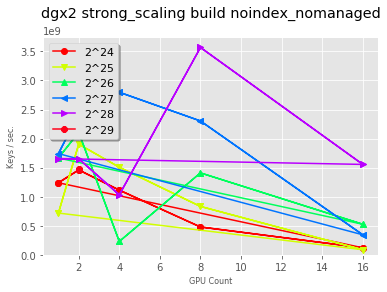

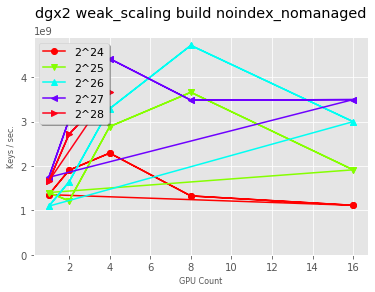

Managed Memory Plots


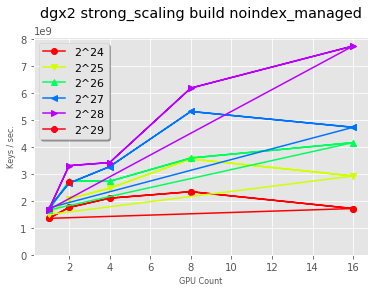

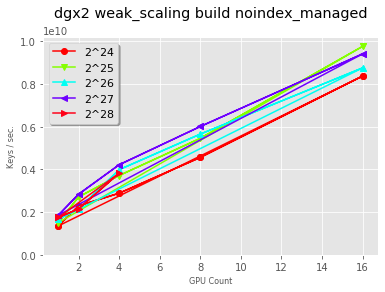

In [47]:
print("Unmanaged Memory Plots")
system = "dgx2"
for exp_type in EXP_TYPES:
    if exp_type == "intersect":
        continue
    for exp in EXPERIMENTS:
        if exp == "duplicate_keys":
            continue
        plotThroughput(system, exp, exp_type, "noindex_nomanaged")
    # plotSpeedup(system, exp, exp_type, "index_nomanaged")
            
print("Managed Memory Plots")
for exp_type in EXP_TYPES:
    if exp_type == "intersect":
        continue
    for exp in EXPERIMENTS:
        if exp == "duplicate_keys":
            continue
        plotThroughput(system, exp, exp_type, "noindex_managed")
        
    # plotSpeedup(system, exp, exp_type, "index_managed")

Unmanaged Memory Plots


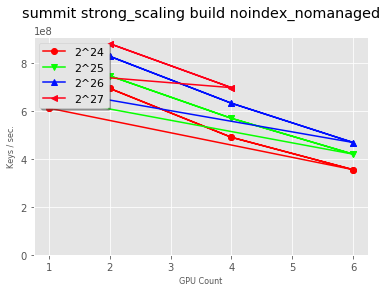

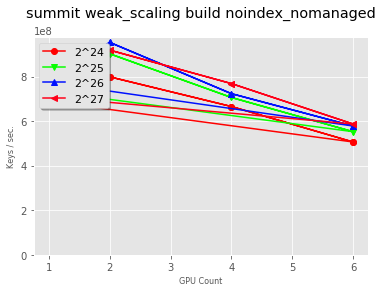

Managed Memory Plots


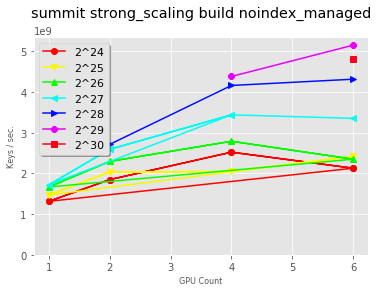

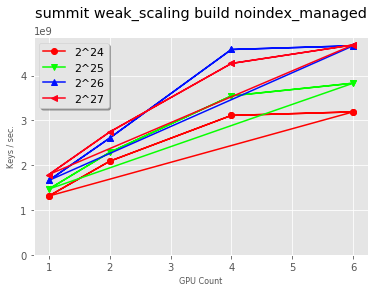

In [48]:
print("Unmanaged Memory Plots")
system = "summit"
for exp_type in EXP_TYPES:
    if exp_type == "intersect":
        continue
    for exp in EXPERIMENTS:
        if exp == "duplicate_keys":
            continue
        plotThroughput(system, exp, exp_type, "noindex_nomanaged")
    # plotSpeedup(system, exp, exp_type, "index_nomanaged")
            
print("Managed Memory Plots")
for exp_type in EXP_TYPES:
    if exp_type == "intersect":
        continue
    for exp in EXPERIMENTS:
        if exp == "duplicate_keys":
            continue
        plotThroughput(system, exp, exp_type, "noindex_managed")
    # plotSpeedup(system, exp, exp_type, "index_managed")